In [1]:
import os
import json
from typing import List, Literal, Optional, Text, Union, Dict, Any
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from agents.agents_modules.workflow import build_agent_workflow
from agents.dataloader import load_dataset_by_name, extract_example

/Users/chinonsoosuji/opt/anaconda3/envs/lang2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


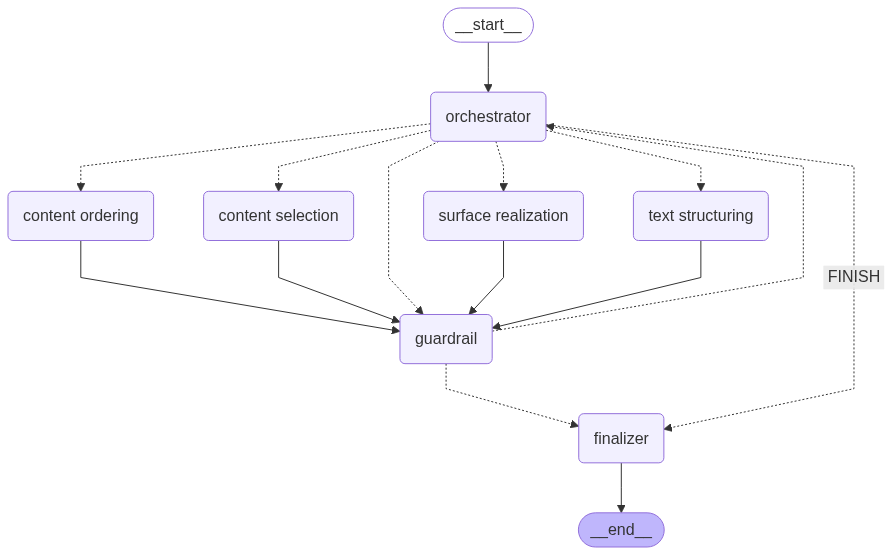

In [2]:
provider = "openai" #ollama, openai, hf, aixplain
process_flow = build_agent_workflow(provider=provider)
display(Image(process_flow.get_graph(xray=True).draw_mermaid_png()))

In [3]:
def save_result_to_json(state: dict, filename: str = "result.json", directory: str = "results") -> None:
    """
    Saves the given agent workflow state to a JSON file in a specified directory.

    Args:
        state (dict): The final state returned by the agent graph execution.
        filename (str): The name of the JSON file to save.
        directory (str): The directory where the file will be saved.

    Raises:
        IsADirectoryError: If the target file path is a directory.
    """

    file_path = os.path.join(directory, filename)
    os.makedirs(directory, exist_ok=True)

    if os.path.isdir(file_path):
        raise IsADirectoryError(f"Cannot write to '{file_path}' because it is a directory.")

    # Recursively convert objects to serializable types
    def make_serializable(obj):
        if isinstance(obj, list):
            return [make_serializable(x) for x in obj]
        elif hasattr(obj, "model_dump"):  # Pydantic BaseModel
            return obj.model_dump()
        elif isinstance(obj, dict):
            return {k: make_serializable(v) for k, v in obj.items()}
        else:
            return obj

    serializable_state = make_serializable(dict(state))

    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(serializable_state, f, indent=4)

    print(f"Results saved to {file_path}")


In [4]:
# Exclude turku_hockey and conversational_weather
# totto, webnlg, dart, rotowire, sportsett_basketball, mlb
name = "rotowire"  
num = -101 # Sample id

data = load_dataset_by_name(name)
sample = extract_example(name, data["train"][num])
data = sample.get('input', '')
ground_truth = sample.get('references', "")
target = sample.get('target', "")

query = f"""You are an agent designed to generate text from data for a data-to-text natural language generation. You can be provided data in the form of xml, table, meaning representations, graphs etc. 
Your task is to generate the appropriate text given the data information without omitting any field or adding extra information in essence called hallucination.
Here is the data generate text using table data:
{data}"""

print(f"Input: {data}")
print(f"Target: {target}")
print(f"Ground Truth: {ground_truth}")

Loading dataset: rotowire
Input: {'AST': {'0': '3', '1': '3', '10': 'N/A', '11': 'N/A', '12': 'N/A', '13': '2', '14': '2', '15': '1', '16': '1', '17': '12', '18': '3', '19': '1', '2': '4', '20': '1', '21': '4', '22': '0', '23': '2', '24': 'N/A', '25': 'N/A', '26': None, '27': None, '28': None, '29': None, '3': '5', '30': None, '31': None, '32': None, '33': None, '34': None, '35': None, '36': None, '37': None, '38': None, '39': None, '4': '6', '5': '2', '6': '1', '7': '0', '8': 'N/A', '9': 'N/A'}, 'BLK': {'0': '0', '1': '0', '10': 'N/A', '11': 'N/A', '12': 'N/A', '13': '1', '14': '2', '15': '0', '16': '0', '17': '1', '18': '1', '19': '0', '2': '0', '20': '0', '21': '0', '22': '0', '23': '0', '24': 'N/A', '25': 'N/A', '26': None, '27': None, '28': None, '29': None, '3': '0', '30': None, '31': None, '32': None, '33': None, '34': None, '35': None, '36': None, '37': None, '38': None, '39': None, '4': '0', '5': '1', '6': '2', '7': '0', '8': 'N/A', '9': 'N/A'}, 'DREB': {'0': '8', '1': '5', '1

In [5]:
initial_state = {
    "user_prompt": query,
    "raw_data": data,
    "history_of_steps": [],
    "final_response": "",
    "next_agent": "",
    "next_agent_payload": "",
    "current_step": 0,
    "iteration_count": 0,
    "max_iteration": 60,
}

state = process_flow.invoke(initial_state, config={"recursion_limit": initial_state["max_iteration"]})
prediction = state['final_response']

ORCHESTRATOR OUTPUT: Thought: I need to extract relevant information from the provided structured data, specifically basketball player statistics, and format it according to the specifications given. This includes ensuring that I only take meaningful entries for players without any "N/A" or None values in essential performance metrics. The data is quite detailed, and I need to ensure all attributes are accurately represented for each player before proceeding to the next worker. 

Worker: content selection
Worker Input: 
Here's the structured data in table format. Please extract all relevant player statistics, ensuring that you connect each attribute with its corresponding player name and team. Format your output as specified, ensuring clarity and coherence for each entry. Focus on essential stats and avoid any entries that do not have a value.

```json
{
  'AST': {...},
  'BLK': {...},
  'DREB': {...},
  'FG3A': {...},
  'FG3M': {...},
  'FG3_PCT': {...},
  'FGA': {...},
  'FGM': {...}

In [6]:
save_result_to_json(state, filename=f"{name}_{num}.json")

Results saved to results/rotowire_-101.json


In [7]:
prediction

'TJ Warren played 41 minutes and scored 29 points, with 3 assists, 9 rebounds, including 8 defensive and 1 offensive rebound. He made 11 field goals on 17 attempts, achieving a field goal percentage of 65%. Additionally, he successfully made 3 out of 5 three-point attempts, resulting in a three-point percentage of 60%, and he completed all 4 free throw attempts for a perfect free throw percentage of 100%. Furthermore, he recorded 4 steals, had no blocks or turnovers, and committed 3 personal fouls. PJ Tucker played 42 minutes and scored 22 points, contributing with 3 assists, 7 rebounds—5 of which were defensive and 2 offensive. He made 10 field goals on 14 attempts, which gives him a field goal percentage of 71%. He also made 2 out of 4 three-point shots, leading to a three-point percentage of 50%. PJ Tucker did not attempt any free throws and recorded 3 steals, had no blocks, 1 turnover, and committed 4 personal fouls.'

In [8]:
ground_truth

''

In [9]:
target

"Even career highs from T.J. Warren ( 29 points ) and P.J . Tucker ( 22 points ) were n't enough to counteract the Thunder 's stars . Russell Westbrook had 36 points and 12 assists , and Kevin Durant chipped in 23 points to beat the Suns 110 - 106 . Phoenix hung in there with the Thunder , never letting the score get away from them . Even when OKC built a 9 - point lead with 7:37 left in the 4th quarter , the Suns kept plugging away . A 70 run late in the quarter , capped by a long 2 - pointer by Tucker , tied the game at 100 . Unfortunately , Tyson Chandler failed to convert a 3 - point play that would have put Phoenix ahead 103 - 102 . That was followed by four points from Durant to put the Thunder up 106 - 102 . A layup by Brandon Knight cut the lead to two with 29 seconds remaining , but Russell Westbrook hit two free throws after being intentionally fouled that extended the lead to four again . A dunk by Knight cut it back to two ; however , Westbrook hit two more free throws and 

In [11]:
from agents.evaluator import evaluate_single

scores = evaluate_single(target, prediction, data)
for metric, score in scores.items():
    print(f"{metric}: {score:.4f}")

/Users/chinonsoosuji/opt/anaconda3/envs/lang2/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 45789.34it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/Users/chinonsoosuji/opt/anaconda3/envs/lang2/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model st

ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434